# CAM类激活热力图可解释性分析

调用自己训练的水果图像分类模型，对单张图像进行图像分类预测，生成CAM类别激活热力图，进行可解释性分析。

同济子豪兄：https://space.bilibili.com/1900783

参考教程：

https://github.com/TommyZihao/Train_Custom_Dataset/tree/main/图像分类

https://mp.weixin.qq.com/s?__biz=MzI4MDcxNTY2MQ==&mid=2247485910&idx=1&sn=22aa21397b003cf40af279ae3acccac1&chksm=ebb50134dcc288220d3f941bcd8b613494c7e1371435e909c9f6e522c21e194f50c7b68f4cc4&token=1125533908&lang=zh_CN#rd

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

2022-8-16

## 进入 mmclassification 目录

In [1]:
import os
os.chdir('mmclassification')

## 设置matplotlib中文字体

In [2]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [4]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2022-08-17 12:01:51--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  17.1MB/s    in 0.6s    

2022-08-17 12:01:52 (17.1 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



## 导入工具包

In [5]:
import pandas as pd
import numpy as np

import torch

import cv2
from PIL import Image

import mmcv
from mmcls.apis import init_model, inference_model, show_result_pyplot

import matplotlib.pyplot as plt
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入类别和ID的映射信息

In [6]:
labels_to_idx = np.load('labels_to_idx.npy', allow_pickle=True).item()

In [7]:
labels_to_idx

{'哈密瓜': 0,
 '圣女果': 1,
 '山竹': 2,
 '杨梅': 3,
 '柚子': 4,
 '柠檬': 5,
 '桂圆': 6,
 '梨': 7,
 '椰子': 8,
 '榴莲': 9,
 '火龙果': 10,
 '猕猴桃': 11,
 '石榴': 12,
 '砂糖橘': 13,
 '胡萝卜': 14,
 '脐橙': 15,
 '芒果': 16,
 '苦瓜': 17,
 '苹果-红': 18,
 '苹果-青': 19,
 '草莓': 20,
 '荔枝': 21,
 '菠萝': 22,
 '葡萄-白': 23,
 '葡萄-红': 24,
 '西瓜': 25,
 '西红柿': 26,
 '车厘子': 27,
 '香蕉': 28,
 '黄瓜': 29}

## 生成CAM类激活热力图

In [5]:
!python tools/visualizations/vis_cam.py \
        test_img/banana_kiwi.jpg \
        configs/mobilenet_v2/mobilenet_v2_1x_fruit30.py \
        work_dirs/mobilenet_v2_1x_fruit30/latest.pth \
        --target-category 11 \
        --method GradCAM \
        --save-path cam.jpg

load checkpoint from local path: work_dirs/mobilenet_v2_1x_fruit30/latest.pth
Automatically choose the last norm layer as target_layer.


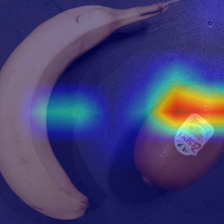

In [6]:
Image.open('cam.jpg')

## 批量生成各种类别、各种方法的热力图

In [8]:
# 创建文件夹
os.mkdir('cam_images')

In [8]:
methods = ['GradCAM', 'GradCAM++', 'XGradCAM', 'EigenCAM', 'EigenGradCAM', 'LayerCAM']
fruits = ['香蕉', '猕猴桃', '柠檬']

In [9]:
for fruit in fruits:
    fruit_id = labels_to_idx[fruit]
    n = len(methods)
    
    for idx, method in enumerate(methods):
        # 生成 CAM 图保存路径
        img_path = 'cam_images/{}_{}.jpg'.format(fruit, method)
        
        # 运行命令行，保存图像
        prompt = '''
        python tools/visualizations/vis_cam.py \
        test_img/banana_kiwi.jpg \
        configs/mobilenet_v2/mobilenet_v2_1x_fruit30.py \
        work_dirs/mobilenet_v2_1x_fruit30/latest.pth \
        --target-category {} \
        --method {} \
        --save-path {}
        '''.format(fruit_id, method, img_path)
        os.system(prompt)
        
        print('图像已保存', img_path)
print('CAM图像生成完成')

load checkpoint from local path: work_dirs/mobilenet_v2_1x_fruit30/latest.pth
Automatically choose the last norm layer as target_layer.
图像已保存 cam_images/香蕉_GradCAM.jpg
load checkpoint from local path: work_dirs/mobilenet_v2_1x_fruit30/latest.pth
Automatically choose the last norm layer as target_layer.
图像已保存 cam_images/香蕉_GradCAM++.jpg
load checkpoint from local path: work_dirs/mobilenet_v2_1x_fruit30/latest.pth
Automatically choose the last norm layer as target_layer.
图像已保存 cam_images/香蕉_XGradCAM.jpg
load checkpoint from local path: work_dirs/mobilenet_v2_1x_fruit30/latest.pth
Automatically choose the last norm layer as target_layer.
图像已保存 cam_images/香蕉_EigenCAM.jpg
load checkpoint from local path: work_dirs/mobilenet_v2_1x_fruit30/latest.pth
Automatically choose the last norm layer as target_layer.
图像已保存 cam_images/香蕉_EigenGradCAM.jpg
load checkpoint from local path: work_dirs/mobilenet_v2_1x_fruit30/latest.pth
Automatically choose the last norm layer as target_layer.
图像已保存 cam_image

## 批量可视化展示

In [10]:
os.chdir('cam_images')

In [11]:
!rm -rf .ipynb_checkpoints

In [12]:
os.listdir()

['香蕉_GradCAM.jpg',
 '香蕉_GradCAM++.jpg',
 '香蕉_XGradCAM.jpg',
 '香蕉_EigenCAM.jpg',
 '香蕉_EigenGradCAM.jpg',
 '香蕉_LayerCAM.jpg',
 '猕猴桃_GradCAM.jpg',
 '猕猴桃_GradCAM++.jpg',
 '猕猴桃_XGradCAM.jpg',
 '猕猴桃_EigenCAM.jpg',
 '猕猴桃_EigenGradCAM.jpg',
 '猕猴桃_LayerCAM.jpg',
 '柠檬_GradCAM.jpg',
 '柠檬_GradCAM++.jpg',
 '柠檬_XGradCAM.jpg',
 '柠檬_EigenCAM.jpg',
 '柠檬_EigenGradCAM.jpg',
 '柠檬_LayerCAM.jpg']

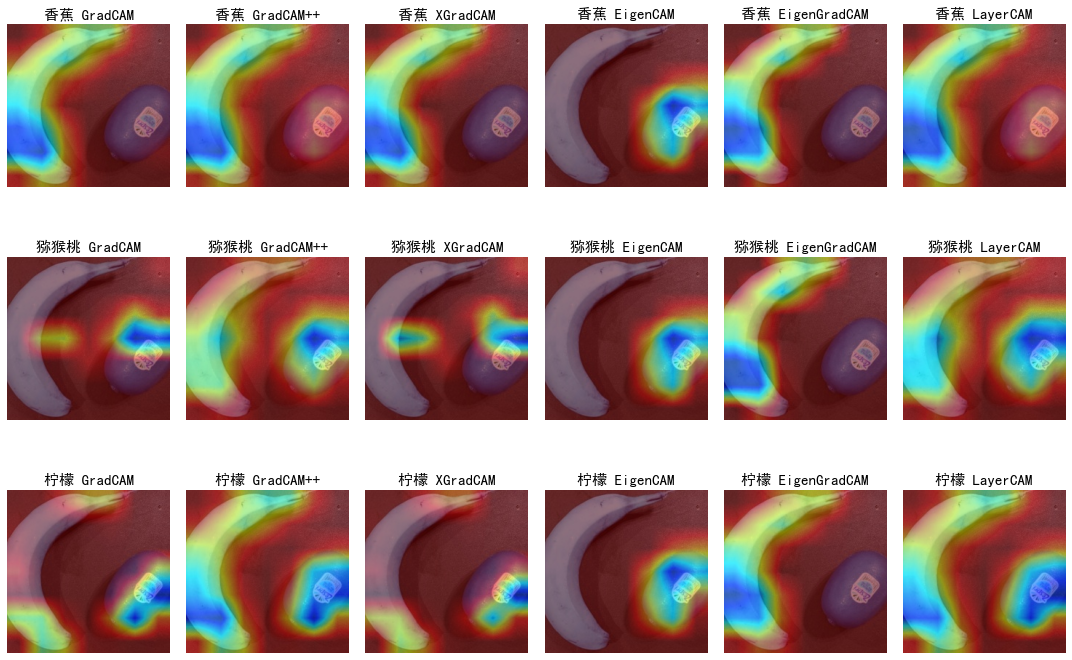

In [13]:
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(os.listdir()):
    plt.subplot(len(fruits), 6, i+1)
    fruit = img_path.split('_')[0]
    method = img_path.split('_')[1].split('.')[0]
    img_array = cv2.imread(img_path)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(fruit + ' ' + method, fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)#调整子图间距 # 调整子图间距，hspace控制纵向间距，wspace控制横向间距
plt.show()